In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import train as tr
from model import get_model
import dataset
from torch.utils.data import DataLoader
from defaults import _C as cfg
from tqdm import tqdm
from collections import OrderedDict
import torch.nn.functional as F

from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

import csv
import os

from datasets import load_dataset

from time import time

from PIL import Image
import PIL
from PIL import JpegImagePlugin

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
df = (pd.read_csv('train_gender.csv')
      .assign(gender = lambda df : df.gender.apply(lambda x : 0 if x == 'female' else 1))
      )
df.head()

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age,gender
0,000000.jpg,36,5.000000,1.146423,4,1
1,000001.jpg,63,20.079365,4.096819,18,0
2,000002.jpg,38,76.815789,6.133009,80,0
3,000003.jpg,38,55.657895,7.864653,50,0
4,000004.jpg,15,17.666667,3.457222,17,0


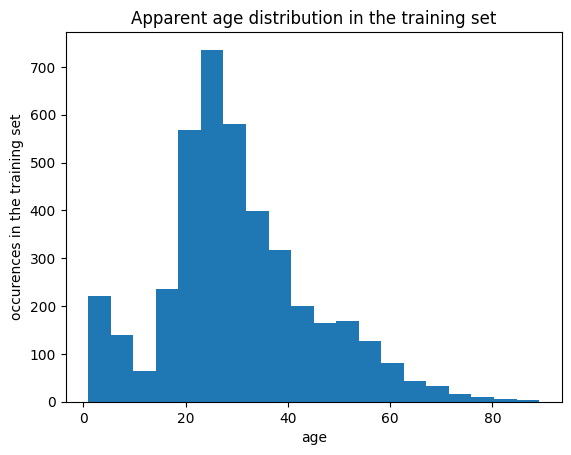

In [16]:
plt.hist(df['apparent_age_avg'], bins=20)
plt.xlabel('age')
plt.ylabel('occurences in the training set')
plt.title('Apparent age distribution in the training set')
plt.show()

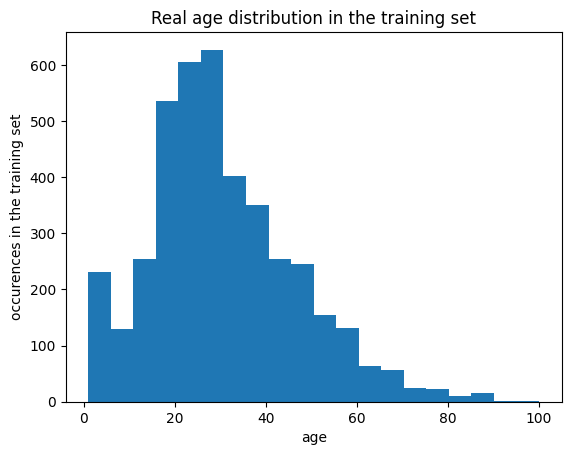

In [17]:
plt.hist(df['real_age'], bins=20)
plt.xlabel('age')
plt.ylabel('occurences in the training set')
plt.title('Real age distribution in the training set')
plt.show()

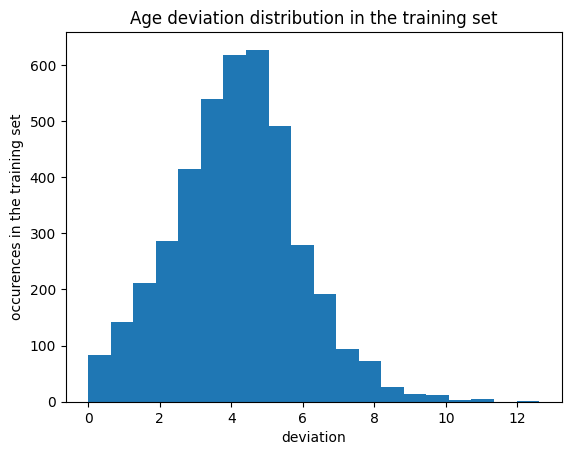

In [19]:
plt.hist(df['apparent_age_std'], bins=20)
plt.xlabel('deviation')
plt.ylabel('occurences in the training set')
plt.title('Age deviation distribution in the training set')
plt.show()

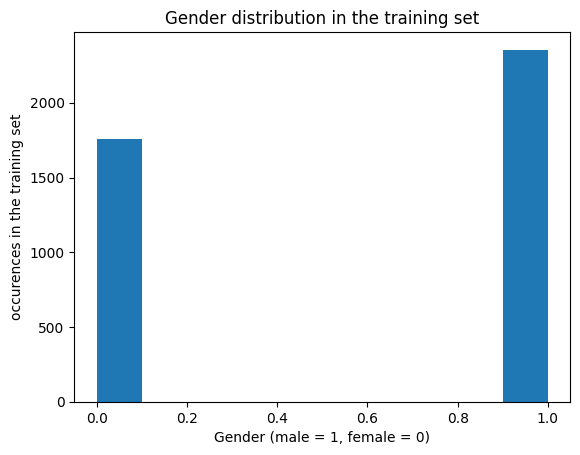

In [224]:
plt.hist(df['gender'])
plt.xlabel('Gender (male = 1, female = 0)')
plt.ylabel('occurences in the training set')
plt.title('Gender distribution in the training set')
plt.show()

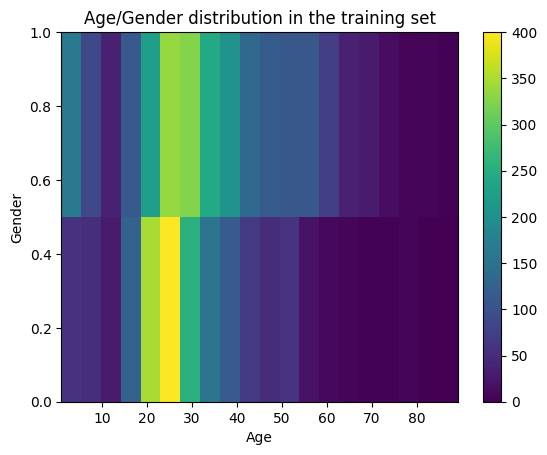

In [25]:
h = plt.hist2d(df['apparent_age_avg'], df['gender'], bins = [20,2])
plt.xlabel('Age')
plt.ylabel('Gender')
plt.title('Age/Gender distribution in the training set')
plt.colorbar(h[3])
plt.show()

In [181]:
h

(array([[ 58., 164.],
        [ 52.,  87.],
        [ 29.,  36.],
        [125., 110.],
        [347., 222.],
        [400., 336.],
        [255., 325.],
        [156., 242.],
        [113., 205.],
        [ 68., 133.],
        [ 49., 115.],
        [ 60., 108.],
        [ 19., 108.],
        [  9.,  72.],
        [  6.,  37.],
        [  3.,  29.],
        [  2.,  14.],
        [  6.,   4.],
        [  1.,   5.],
        [  0.,   3.]]),
 array([ 0.92307692,  5.33461538,  9.74615385, 14.15769231, 18.56923077,
        22.98076923, 27.39230769, 31.80384615, 36.21538462, 40.62692308,
        45.03846154, 49.45      , 53.86153846, 58.27307692, 62.68461538,
        67.09615385, 71.50769231, 75.91923077, 80.33076923, 84.74230769,
        89.15384615]),
 array([0. , 0.5, 1. ]),
 <matplotlib.collections.QuadMesh at 0x19ef8c6a690>)

In [33]:
model = get_model()
ck = torch.load('misc/epoch044_0.02343_3.9984.pth')
model.load_state_dict(ck['state_dict'])
model = model.to(device)

In [56]:
data_dir = './appa-real-release'
valid_dataset = dataset.FaceDataset(data_dir, 'valid', img_size=cfg.MODEL.IMG_SIZE)
valid_loader =  DataLoader(valid_dataset, batch_size=32, shuffle=False, drop_last=False)

valid_img_names = pd.read_csv(data_dir+'/gt_avg_valid.csv')['file_name'].to_numpy()

In [57]:
print(valid_img_names)

['004113.jpg' '004114.jpg' '004115.jpg' ... '005610.jpg' '005611.jpg'
 '005612.jpg']


In [64]:
criterion = torch.nn.CrossEntropyLoss().to(device)

def validate(validate_loader, model, criterion, epoch, device, names):
    model.eval()
    loss_monitor = tr.AverageMeter()
    accuracy_monitor = tr.AverageMeter()
    preds = []
    gt = []

    with torch.no_grad():
        with tqdm(validate_loader) as _tqdm:
            for x, y in _tqdm:
                x = x.to(device)
                y = y.type(torch.LongTensor)
                y = y.to(device)

                # compute output
                outputs = model(x)
                preds.append(F.softmax(outputs, dim=-1).cpu().numpy())
                gt.append(y.cpu().numpy())

                # valid for validation, not used for test
                if criterion is not None:
                    # calc loss
                    loss = criterion(outputs, y)
                    cur_loss = loss.item()

                    # calc accuracy
                    _, predicted = outputs.max(1)
                    correct_num = predicted.eq(y).sum().item()

                    # measure accuracy and record loss
                    sample_num = x.size(0)
                    loss_monitor.update(cur_loss, sample_num)
                    accuracy_monitor.update(correct_num, sample_num)
                    _tqdm.set_postfix(OrderedDict(stage="val", epoch=epoch, loss=loss_monitor.avg),
                                      acc=accuracy_monitor.avg, correct=correct_num, sample_num=sample_num)

    preds = np.concatenate(preds, axis=0)
    gt = np.concatenate(gt, axis=0)
    ages = np.arange(0, 101)
    ave_preds = (preds * ages).sum(axis=-1)
    diff = ave_preds - gt
    mae = np.abs(diff).mean()

    df2 = pd.DataFrame({'img_name' : names, 'ground_truth': gt, 'prediction': ave_preds})

    return df2, loss_monitor.avg, accuracy_monitor.avg, mae

df2, loss_avg, acc_avg, mae = validate(valid_loader, model, criterion, 4, device, valid_img_names)

100%|██████████| 47/47 [00:18<00:00,  2.60it/s, stage=val, epoch=4, loss=0.0918, acc=0.119, correct=3, sample_num=28]


In [65]:
df2.head()

,img_name,ground_truth,prediction
0,004113.jpg,26,29.615194
1,004114.jpg,27,27.965993
2,004115.jpg,23,24.636010
3,004116.jpg,73,6.903652
4,004117.jpg,20,26.175875


In [67]:
print("")
print("Chargement du modèle...")

processor = AutoImageProcessor.from_pretrained("rizvandwiki/gender-classification")
model = AutoModelForImageClassification.from_pretrained("rizvandwiki/gender-classification")

print("Modèle chargé")

#for i in range(N):
 #   print(i)
  #  input = processor(dataset[i], return_tensor = 'pt')

donnees = [["img_name","gender"]]
genders_dict = model.config.id2label

#quit()
dataset = [
        Image.open("appa-real-release/valid/"+x).convert('RGB') for x in valid_img_names
    ]
t = time()
print("Processing...")

inputs = processor(dataset, return_tensors="pt")

print(f"Processing achieved in {time()-t} s")
#

t= time()
print("Classification ...")

with torch.no_grad():
    #logits = []
    #for i in range(N):
    #    print(i)
    #    logits.append(model(inputs[i]).logits)

    logits = model(**inputs).logits
#print(logits)

predicted_labels = torch.argmax(logits,-1).tolist()

print(f"Classification achieved in {time()-t}")
gender_list = [genders_dict[predicted_labels[i]] for i in range(len(valid_img_names))]


Chargement du modèle...
Modèle chargé
Processing...
Processing achieved in 28.122684478759766 s
Classification ...
Classification achieved in 529.0463855266571


In [69]:
df2 = df2.assign(gender = gender_list)

In [71]:
df2 = df2.assign(diff = lambda df : df.apply(lambda x : np.abs(x.ground_truth - x.prediction), axis = 1))

In [77]:
c = 0
for i in df2.index:
    if df2['diff'][i]>10:
        c+=1
        diff = df2['diff'][i]
        name = df2['img_name'][i]
        print(df2.loc[i])
        print("")
print(c)

img_name        004116.jpg
ground_truth            73
prediction        6.903652
gender              female
diff             66.096348
Name: 3, dtype: object

img_name        004121.jpg
ground_truth             5
prediction       28.218247
gender              female
diff             23.218247
Name: 8, dtype: object

img_name        004123.jpg
ground_truth            30
prediction       45.827942
gender                male
diff             15.827942
Name: 10, dtype: object

img_name        004144.jpg
ground_truth            63
prediction       48.325248
gender                male
diff             14.674752
Name: 31, dtype: object

img_name        004145.jpg
ground_truth             2
prediction       40.153798
gender              female
diff             38.153798
Name: 32, dtype: object

img_name        004159.jpg
ground_truth            62
prediction       51.242336
gender              female
diff             10.757664
Name: 46, dtype: object

img_name        004161.jpg
ground_truth   

In [140]:
sus_outliers = []
for i in df2.index:
    if df2['diff'][i]>10:
        name = df2['img_name'][i]
        sus_outliers.append(name)
outl = df2.set_index('img_name').loc[sus_outliers]

In [112]:
outl = outl.sort_values('diff', ascending=False).reset_index().drop(0).reset_index(drop=True)
outl#.loc[range(20)]
#outl.index

,img_name,ground_truth,prediction,gender,diff
0,005113.jpg,56,9.733888,male,46.266112
1,005280.jpg,63,18.626941,male,44.373059
2,004535.jpg,25,64.634528,female,39.634528
3,004902.jpg,5,44.633959,male,39.633959
4,004145.jpg,2,40.153798,female,38.153798
...,...,...,...,...,...
110,005153.jpg,49,38.898399,female,10.101601
111,004347.jpg,27,37.034034,male,10.034034
112,004274.jpg,46,35.973770,male,10.026230
113,004396.jpg,58,47.998006,male,10.001994


In [137]:
outl = outl.drop(51).reset_index(drop=True)
outl.loc[range(40,60)]

,img_name,ground_truth,prediction,gender,diff
40,004264.jpg,31,44.027240,male,13.027240
41,004452.jpg,42,55.016704,male,13.016704
42,004320.jpg,58,44.984419,male,13.015581
43,004336.jpg,21,8.013614,female,12.986386
44,004585.jpg,48,35.135011,male,12.864989
45,005233.jpg,74,61.344944,male,12.655056
46,004625.jpg,62,49.360557,male,12.639443
47,004346.jpg,24,36.551334,male,12.551334
48,005495.jpg,50,37.463412,male,12.536588
49,004474.jpg,51,38.714211,male,12.285789


In [139]:
real_outliers = sus_outliers.copy()
for x in outl['img_name']:
    real_outliers.remove(x)
print(real_outliers)

['004116.jpg', '004172.jpg', '004218.jpg', '004257.jpg', '004310.jpg', '004351.jpg', '004361.jpg', '004438.jpg', '004534.jpg', '004535.jpg', '004587.jpg', '004722.jpg', '004751.jpg', '004939.jpg', '005104.jpg', '005113.jpg', '005129.jpg', '005161.jpg', '005280.jpg', '005336.jpg', '005415.jpg', '005475.jpg']


In [144]:
#real_outliers.remove('004587.jpg')
outliers = outl.loc[real_outliers].sort_values('diff')

In [145]:
outliers

,ground_truth,prediction,gender,diff
img_name,,,,
004751.jpg,24,36.229284,female,12.229284
004361.jpg,10,22.856955,female,12.856955
004722.jpg,35,21.989318,female,13.010682
005336.jpg,23,36.413916,male,13.413916
004351.jpg,15,1.311172,male,13.688828
004438.jpg,10,23.917678,male,13.917678
004257.jpg,15,29.671648,female,14.671648
005161.jpg,11,26.528944,male,15.528944
004534.jpg,21,36.673525,male,15.673525


In [152]:
df2= df2.set_index('img_name').drop(real_outliers).reset_index()

(array([ 294.20475534,  463.0677533 , 1315.64058071, 1140.30937844,
        847.04552419,  688.96716905,  385.4869503 ,  260.71967373,
         45.52776999,   53.55829238]), array([ 1. ,  9.7, 18.4, 27.1, 35.8, 44.5, 53.2, 61.9, 70.6, 79.3, 88. ]))
(array([117, 133, 444, 342, 196, 126,  71,  38,   7,   5], dtype=int64), array([ 1. ,  9.7, 18.4, 27.1, 35.8, 44.5, 53.2, 61.9, 70.6, 79.3, 88. ]))


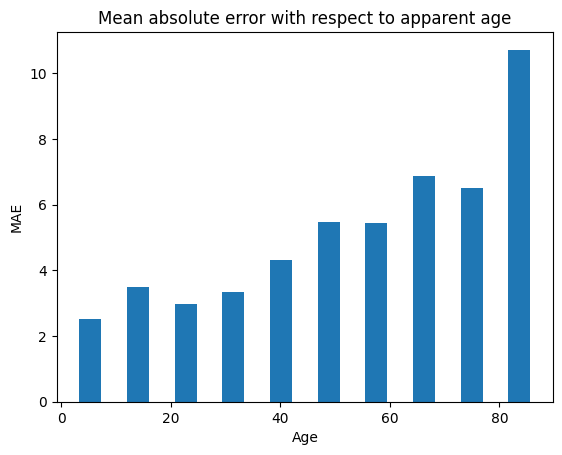

In [221]:
h1 = np.histogram(df2['ground_truth'], weights = df2['diff'])
h2 = np.histogram(df2['ground_truth'])
print(h1)
print(h2)
bar_loc = np.array([np.mean((h1[1][i], h1[1][i+1])) for i in range(len(h1[1])-1)])
h3 = (h1[0]/h2[0], bar_loc)
plt.bar(h3[1], height = h3[0], width=4)
plt.xlabel('Age')
plt.ylabel('MAE')
plt.title('Mean absolute error with respect to apparent age')
plt.show()

(array([2349.56936862, 3144.95847882]), array([0. , 0.5, 1. ]))
(array([621, 858], dtype=int64), array([0. , 0.5, 1. ]))


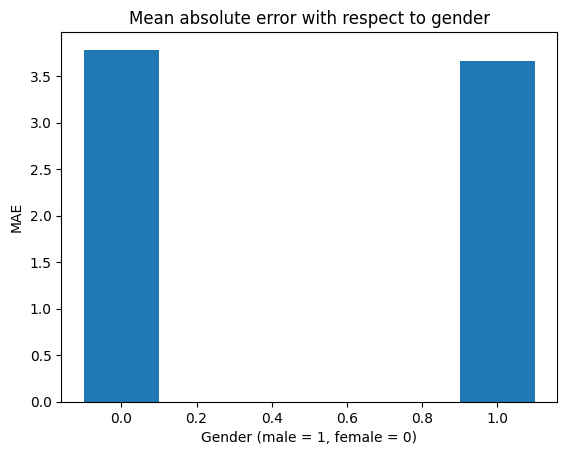

In [223]:
h1 = np.histogram(df2.assign(gender = lambda df : df.gender.apply(lambda x : 0 if x == 'female' else 1))['gender'], weights = df2['diff'], bins=2)
h2 = np.histogram(df2.assign(gender = lambda df : df.gender.apply(lambda x : 0 if x == 'female' else 1))['gender'], bins = 2)
print(h1)
print(h2)
bar_loc = np.array([0,1])
h3 = (h1[0]/h2[0], bar_loc)
plt.bar(h3[1], height = h3[0], width=0.2)
plt.xlabel('Gender (male = 1, female = 0)')
plt.ylabel('MAE')
plt.title('Mean absolute error with respect to gender')
plt.show()

In [192]:
df2.ground_truth.max()

88

[0.003120791829328985, 0.0019393402882035876, 0.018900565275210442, 0.006602521715650861, 0.0024412415425225757, 0.003929936916554054, 0.004693241839833987, 0.00287627659150352, 0.005825038819025173, 0.005062000294145463, 0.009385693075907644, 0.008290512571359489, 0.009003702921040892, 0.030543104221815786, 0.004417408845076658, 0.020621588201166597, 0.0037952374345955977, 0.003828055179365887, 0.007836911496506619, 0.009810877838440079, 0.0022467937447640672, 0.0052164804553767865, 0.01272085946189263, 0.005459557228966702, 0.0036728379172454397, 0.008481667862616648, 0.0019776853861701816, 0.009335591907558543, 0.0029514644039463768, 1.2307676640442466, 0.016853161807009524, 0.009066131067165858, 0.009052283830779745, 0.004525721501626744, 0.007063160504193819, 0.000496046653288739, 0.006959919645667316, 0.01599868558608722, 0.016615346775686414, 0.01440561326559442, 0.06936035902691574, 0.005338088913301675, 0.018539379663497405, 0.35430923411664, 0.037766990859063626, 0.0079940011

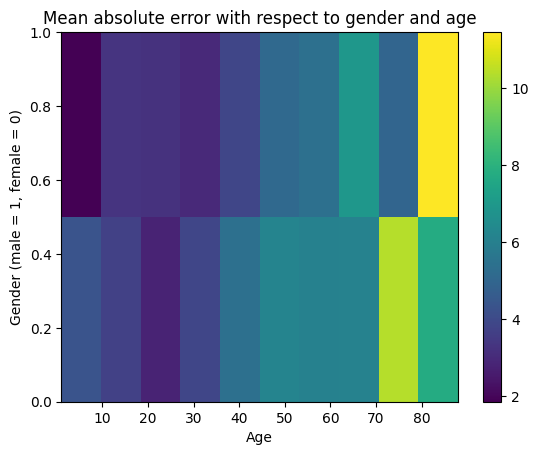

In [225]:
h1 = np.histogram2d(
    df2['ground_truth'], 
    df2.assign(gender = lambda df : df.gender.apply(lambda x : int(0) if x == 'female' else int(1)))['gender'],
    bins = [10,2]
    )
b = h1[1]
#print(b)
norm_diff = []
tmp = df2.assign(gender = lambda df : df.gender.apply(lambda x : 0 if x == 'female' else 1)).sort_values('ground_truth').reset_index(drop=True)[['ground_truth', 'gender', 'diff']].copy()#.to_numpy()
#print(tmp)
j = 0
for i in tmp.index:
    #print(tmp.loc[i]['gender'])
    #print(type(tmp.loc[i]['gender']))
    if tmp.loc[i]['ground_truth']>b[j+1]: 
        j+=1
    #print(j)
    norm_diff.append(tmp.loc[i]['diff']/h1[0][j][int(tmp.loc[i]['gender'])])

print(norm_diff)
print(h1[0])
#bar_loc = np.array([np.mean((h1[1][i], h1[1][i+1])) for i in range(len(h1[1])-1)])
#h3 = (h1[0]/h2[0], bar_loc)
h = plt.hist2d(tmp['ground_truth'], tmp['gender'], bins = [h1[1], h1[2]], weights = norm_diff)
plt.colorbar(h[3])
plt.xlabel('Age')
plt.ylabel('Gender (male = 1, female = 0)')
plt.title('Mean absolute error with respect to gender and age')
plt.show()

In [210]:
(df2
 .assign(gender = lambda df : df.gender.apply(lambda x : 0 if x == 'female' else 1))
 .query("gender==0")
 .query("ground_truth>=18")
 .query("ground_truth<29")
 )#['diff'].mean()

,img_name,ground_truth,prediction,gender,diff
3,004117.jpg,20,26.175875,0,6.175875
4,004118.jpg,25,24.896173,0,0.103827
11,004125.jpg,27,25.845715,0,1.154285
23,004137.jpg,25,22.462579,0,2.537421
26,004140.jpg,24,22.993506,0,1.006494
...,...,...,...,...,...
1469,005603.jpg,28,24.961766,0,3.038234
1472,005606.jpg,23,25.695909,0,2.695909
1474,005608.jpg,18,18.806168,0,0.806168
1475,005609.jpg,24,26.134287,0,2.134287


In [212]:
tmp

,ground_truth,gender,diff
0,1,1,0.268388
1,1,1,0.166783
2,1,1,1.625449
3,1,1,0.567817
4,1,1,0.209947
...,...,...,...
1474,80,1,7.463274
1475,80,0,7.721811
1476,81,1,10.429721
1477,84,1,9.982800
